In [1]:
import csv
from functools import partial
import os
import pickle
import random
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional

import h5py as h5
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

import os
import pickle
import time
from dataclasses import dataclass
from datetime import timedelta
from typing import Callable, List, Optional, Tuple

import h5py as h5
import hydra
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, SequentialSampler
from tqdm import tqdm

from config import ExperimentConfig
# from data.core import ComicsDataset
from data.text_cloze import generate_minibatches_from_megabatch_text_cloze, TextClozeBatch
# from models.lstm import TextOnlyHeirarchicalLSTM
from models.text_only_text_cloze import TextOnlyTextClozeTransformerBaseline


In [2]:
# comics_data_path = '../11711_COMICS/data/comics.h5'
# vgg_feats_path  = '../11711_COMICS/data/vgg_features.h5'
# vocab_path  = '../11711_COMICS/data/comics_vocab.p'
# folds_dir  = '../11711_COMICS/folds'
# difficulty  = 'easy'
# n_epochs  = 10
# megabatch_zsize  = 2
# batch_size  = 2
# iters_to_accumulate  = 2
# num_workers  = 4
# lr  = 1e-6  # Small learning rate for finetuning.
# show_tqdm = False

In [3]:

# data_kwargs = {
#     'batch_gen_fn': batch_gen_fn,
#     **config.data,
#     'difficulty': config.task.difficulty,
#     'batch_size': config.model.batch_size,
#     # 'load_image_feats': True,
# }
# train_dataloader, train_dataset = make_dataloader(**data_kwargs, fold='train')

In [4]:
# outs = next(iter(train_dataloader))   


# out1  = outs[0][0]

# image = out1.context_panel_images

# import matplotlib.pyplot as plt

# image.shape

# all_imgs = image.reshape(-1, 224,224,3)

# bs = all_imgs.shape[0]

# feats = torch.tensor([feature_extractor(all_imgs[i])["pixel_values"][0] for i in range(bs)])

# outputs = feats.reshape(bs, 3, 224, 224)

# outputs.shape

# final = outputs.reshape(5,3,3, 224,224)

# reshaped = final.permute(0,2,1,3,4).reshape(5,3,-1,224)

# reshaped[0].permute()

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


# %%time
# feats = torch.tensor([feature_extractor(image[0][i])["pixel_values"][0] for i in range(3)])

# all_panels = feats.permute(1,2,0, 3).reshape(3, 224, -1)

# plt.imshow(all_panels.permute(1,2,0))

### BERT and VIT

In [5]:
from transformers import ViTModel, ViTConfig
from transformers import ViTFeatureExtractor
device= "cuda"
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# inputs = feature_extractor(images=, return_tensors="pt")
# # [model(**inputs)]
# last_hidden_states = outputs.last_hidden_state

In [6]:
def collate_fn(batches_and_labels: List[List[Tuple[TextClozeBatch, torch.Tensor]]]):
    """
    Dummy collate function to just return the single element from the list (which will
    already be a list of batches), since our dataset does the batching logic.
    """
    print(len(batches_and_labels))
    assert len(batches_and_labels) == 1
    return batches_and_labels[0]

In [7]:
train_dataloader = torch.load("new_train_dataloader.pt")

In [8]:
out1 = next(iter(train_dataloader))

/home/ubuntu/.local/lib/python3.6/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/home/ubuntu/.local/lib/python3.6/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/home/ubuntu/.local/lib/python3.6/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray wi

1
1
1
1
1
1


In [9]:
from transformers import BertTokenizer, VisualBertModel

# word_to_idx, idx_to_word = pickle.load(open(vocab_path, 'rb'), encoding='bytes')
# word_to_idx = {k.decode('utf-8'): v for k, v in word_to_idx.items()}
# idx_to_word = {k: v.decode('utf-8') for k, v in idx_to_word.items()}

In [10]:
batches = out1[0]

In [11]:
batch, label = batches

In [34]:
# save best model for (Answer id and correct label)
# work on loss, the spell checking and also VIT for words

In [21]:
model = ImageTextVisualClozeTransformerBaseline()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
model.train()
model.to(device);

In [114]:
vit_model = ViTModel.from_pretrained(
    'google/vit-base-patch16-224-in21k'
).to(device)

lstm_panel = nn.LSTM(
    input_size=768,
    hidden_size=768,
    batch_first=True,
).to(device)

#combine text and image in linear layer

input_linear = 2 * 3 * 768 # 2 layers * 3 panels n_context * 768 hidden_size
output_linear = 3 * 768 # 3 panels n_context * 768 hidden_size

linear = nn.Linear(input_linear, output_linear).to(device)

In [127]:
batch_size = batch.batch_size
n_context = batch.n_context
# print(batch_size, n_context)

# text embeddings
panel_embeddings = model._get_bert_embeddings(batch.context_panel_bert_input)
# print(panel_embeddings.shape)
panel_embeddings = panel_embeddings.reshape(batch_size, n_context, -1)
# print(panel_embeddings.shape)

# image embeddings.
panel_image_embeddings = model._get_visual_embeddings(
    batch.context_panel_vit_input
)
panel_image_embeddings = panel_image_embeddings.reshape(
    batch_size, n_context, -1
)

### get combined image and text ###
combined_image_text = torch.stack([panel_embeddings, panel_image_embeddings],axis=1)#.reshape(batch_size, n_context, -1)

#need to flatten to get linear + put through
input_to_linear = combined_image_text.reshape(batch_size, -1)
out_linear = linear(input_to_linear)
input_image_text = out_linear.reshape(batch_size, n_context, -1)

#lstm with both image and text data:
_, (_, context_embeddings) = lstm_panel(input_image_text)
context_embeddings = context_embeddings.reshape(batch_size, -1, 1)

# Answer embeddings.
answer_panel_image_embeddings = model._get_visual_embeddings(
    batch.answer_panel_vit_input
)
answer_panel_image_embeddings = answer_panel_image_embeddings.reshape(
    batch_size, 3, -1
)

# TODO: try cosine simlarity as well
scores = torch.bmm(answer_panel_image_embeddings, context_embeddings)
scores = scores.reshape(batch_size, 3)

In [119]:
input_to_linear.shape

torch.Size([4, 4608])

In [123]:
context_embeddings.shape

torch.Size([4, 768, 1])

In [126]:
scores

tensor([[ 1.0431,  0.4173,  1.1043],
        [ 1.0113,  0.6376,  1.4305],
        [ 0.3187, -0.2895,  0.6238],
        [ 1.3267,  0.9730,  0.3411]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

### BERT work:

In [20]:
from typing import Dict, List

import torch
import torch.nn as nn
from transformers import (
    BertTokenizer,
    BertModel,
    DistilBertTokenizer,
    DistilBertModel,
    ViTFeatureExtractor,
    ViTModel,
)

from data.text_cloze import TextClozeBatch
from data.visual_cloze import VisualClozeBatch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ImageTextVisualClozeTransformerBaseline(nn.Module):
    def __init__(self, use_distilbert=False):
        super(ImageTextVisualClozeTransformerBaseline, self).__init__()

        self.use_distilbert = use_distilbert
        if use_distilbert:
            self.bert_model = DistilBertModel.from_pretrained(
                'distilbert-base-uncased'
            ).to(device)
        else:
            self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

        self.vit_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224-in21k'
        ).to(device)

        self.lstm_panel = nn.LSTM(
            input_size=768,
            hidden_size=768,
            batch_first=True,
        )
        
        input_linear = 2 * 3 * 768 # 2 layers * 3 panels n_context * 768 hidden_size
        output_linear = 3 * 768 # 3 panels n_context * 768 hidden_size

        self.linear = nn.Linear(input_linear, output_linear).to(device)

    def forward(self, batch: VisualClozeBatch):
        batch_size = batch.batch_size
        n_context = batch.n_context

        # text embeddings
        panel_embeddings = self._get_bert_embeddings(batch.context_panel_bert_input)
        # print(panel_embeddings.shape)
        panel_embeddings = panel_embeddings.reshape(batch_size, n_context, -1)
        # print(panel_embeddings.shape)

        # image embeddings.
        panel_image_embeddings = self._get_visual_embeddings(
            batch.context_panel_vit_input
        )
        panel_image_embeddings = panel_image_embeddings.reshape(
            batch_size, n_context, -1
        )

        ### get combined image and text ###
        combined_image_text = torch.stack([panel_embeddings, panel_image_embeddings],axis=1)

        #need to flatten to get linear + put through
        input_to_linear = combined_image_text.reshape(batch_size, -1)
        out_linear = self.linear(input_to_linear)
        input_image_text = out_linear.reshape(batch_size, n_context, -1)

        #lstm with both image and text data:
        _, (_, context_embeddings) = self.lstm_panel(input_image_text)
        context_embeddings = context_embeddings.reshape(batch_size, -1, 1)

        # Answer embeddings.
        answer_panel_image_embeddings = self._get_visual_embeddings(
            batch.answer_panel_vit_input
        )
        answer_panel_image_embeddings = answer_panel_image_embeddings.reshape(
            batch_size, 3, -1
        )

        # TODO: try cosine simlarity as well
        scores = torch.bmm(answer_panel_image_embeddings, context_embeddings)
        scores = scores.reshape(batch_size, 3)
        
        return scores

    def _get_bert_embeddings(self, bert_input: Dict):
        for key, tensor in bert_input.items():
            if isinstance(tensor, torch.Tensor):
                bert_input[key] = tensor.to(device, non_blocking=True)

        bert_outputs = self.bert_model(**bert_input)

        if self.use_distilbert:
            return bert_outputs[0][
                :, 0
            ]  # Distilbert returns a tuple where the 1st thing is hidden state.
        return bert_outputs.pooler_output

    def _get_visual_embeddings(self, vit_input: Dict):
        for key, tensor in vit_input.items():
            if isinstance(tensor, torch.Tensor):
                vit_input[key] = tensor.to(device, non_blocking=True)
        vit_outputs = self.vit_model(**vit_input)
        return vit_outputs.pooler_output


In [15]:
from typing import Dict, List

import torch
import torch.nn as nn
from transformers import (
    BertTokenizer,
    BertModel,
    DistilBertTokenizer,
    DistilBertModel,
    ViTFeatureExtractor,
    ViTModel,
)

from data.text_cloze import TextClozeBatch
from data.visual_cloze import VisualClozeBatch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TextOnlyVisualClozeTransformerBaseline(nn.Module):
    def __init__(self, use_distilbert=False):
        super(TextOnlyVisualClozeTransformerBaseline, self).__init__()

        self.use_distilbert = use_distilbert
        if use_distilbert:
            # self.bert_tokenizer = DistilBertTokenizer.from_pretrained(
            #     'distilbert-base-uncased'
            # )
            self.bert_model = DistilBertModel.from_pretrained(
                'distilbert-base-uncased'
            ).to(device)
        else:
            # self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

        self.vit_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224-in21k'
        ).to(device)

        self.lstm_panel = nn.LSTM(
            input_size=768,
            hidden_size=768,
            batch_first=True,
        )

    def forward(self, batch: VisualClozeBatch):
        batch_size = batch.batch_size
        n_context = batch.n_context

        panel_embeddings = self._get_bert_embeddings(batch.context_panel_bert_input)
        panel_embeddings = panel_embeddings.reshape(batch_size, n_context, -1)

        _, (_, context_embeddings) = self.lstm_panel(panel_embeddings)
        context_embeddings = context_embeddings.reshape(batch_size, -1, 1)

        # Answer embeddings.
        answer_panel_image_embeddings = self._get_visual_embeddings(
            batch.answer_panel_vit_input
        )
        answer_panel_image_embeddings = answer_panel_image_embeddings.reshape(
            batch_size, 3, -1
        )

        # TODO: try cosine simlarity as well
        scores = torch.bmm(answer_panel_image_embeddings, context_embeddings)
        scores = scores.reshape(batch_size, 3)

        return scores

    def _get_bert_embeddings(self, bert_input: Dict):
        for key, tensor in bert_input.items():
            if isinstance(tensor, torch.Tensor):
                bert_input[key] = tensor.to(device, non_blocking=True)

        bert_outputs = self.bert_model(**bert_input)

        if self.use_distilbert:
            return bert_outputs[0][
                :, 0
            ]  # Distilbert returns a tuple where the 1st thing is hidden state.
        return bert_outputs.pooler_output

    def _get_visual_embeddings(self, vit_input: Dict):
        for key, tensor in vit_input.items():
            if isinstance(tensor, torch.Tensor):
                vit_input[key] = tensor.to(device, non_blocking=True)
        vit_outputs = self.vit_model(**vit_input)
        return vit_outputs.pooler_output


### Image Preprocessing:

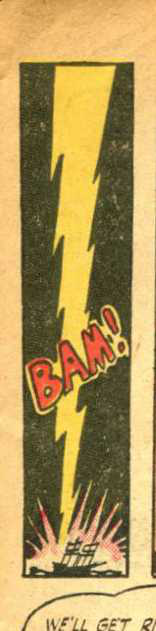

In [15]:
import os
from PIL import Image
dir_path = "../11711_COMICS/data/raw_panel_images/3471"
one_panel = os.listdir(dir_path)

first_panels = sorted(one_panel)[3:6]

panel_paths = [ os.path.join(dir_path, p) for p in first_panels]

Image.open(panel_paths[0])

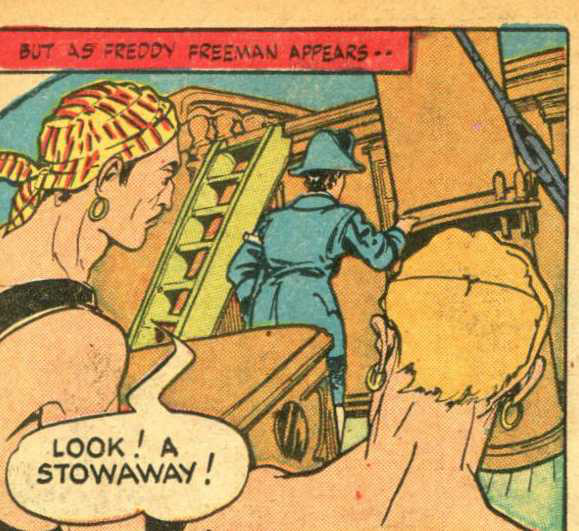

In [16]:
Image.open(panel_paths[1])

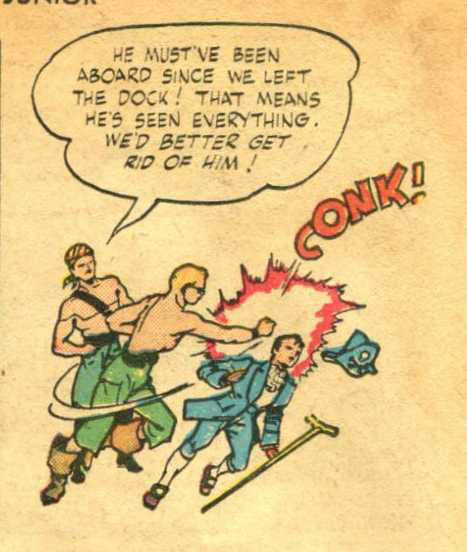

In [17]:
Image.open(panel_paths[2])

### VQA DEMO

In [18]:
# https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=_P5ZDpfKXlHX

In [19]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

NameError: name 'get_cfg' is not defined

### ViT Model

In [ ]:
from transformers import ViTModel, ViTConfig
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
import os
from PIL import Image
dir_path = "../11711_COMICS/data/raw_panel_images/3471"
one_panel = os.listdir(dir_path)

first_panels = sorted(one_panel)[3:6]

panel_paths = [ os.path.join(dir_path, p) for p in first_panels]


inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
last_hidden_states.shape

In [ ]:
from typing import List

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

from data import ComicPanelBatch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TextOnlyTransformerBaseline(nn.Module):
    def __init__(self, idx_to_word, use_distilbert=False):
        super(TextOnlyTransformerBaseline, self).__init__()

        self.idx_to_word = idx_to_word

        self.use_distilbert = use_distilbert
        if use_distilbert:
            self.bert_tokenizer = DistilBertTokenizer.from_pretrained(
                'distilbert-base-uncased'
            )
            self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        else:
            self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

        self.lstm_panel = nn.LSTM(
            input_size=768,
            hidden_size=768,
            batch_first=True,
        )

        # # Freeze BERT parameters.
        # for param in self.bert_model.parameters():
        #     param.requires_grad = False

    def forward(self, batch: ComicPanelBatch):
        # print(f'{batch.context_box_text[0] = }')
        # print(f'{batch.answer_text[0] = }')
        # print(f'{batch.answer_words[0] = }')
        # print(f'{batch.answer_word_masks[0] = }')
        # assert False

        batch_size, n_context, n_boxes_max, n_words_max = batch.context_words.shape

        # Join all 3 of the text boxes in a panel into a single sentence.
        context_box_text_joined = [
            ' '.join(batch.context_box_text[i : i + 3])
            for i in range(0, len(batch.context_box_text), 3)
        ]

        panel_embeddings = self._get_bert_embeddings(context_box_text_joined)
        panel_embeddings = panel_embeddings.reshape(batch_size, n_context, -1)

        # Answer embeddings.
        answer_embeddings = self._get_bert_embeddings(batch.answer_text)
        answer_embeddings = answer_embeddings.reshape(batch_size, 3, -1)

        _, (_, context_embeddings) = self.lstm_panel(panel_embeddings)
        context_embeddings = context_embeddings.reshape(batch_size, -1, 1)

        # TODO: try cosine simlarity as well
        scores = torch.bmm(answer_embeddings, context_embeddings)
        scores = scores.reshape(batch_size, 3)

        return scores

    def _get_bert_embeddings(self, sentences: List[str]):
        bert_input = self.bert_tokenizer(
            sentences,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128,  # shorter sequence length to save memory
        )
        for key, tensor in bert_input.items():
            if isinstance(tensor, torch.Tensor):
                bert_input[key] = tensor.to(device, non_blocking=True)

        bert_outputs = self.bert_model(**bert_input)

        if self.use_distilbert:
            return bert_outputs[0][
                :, 0
            ]  # Distilbert returns a tuple where the 1st thing is hidden state.
        return bert_outputs.pooler_output
